In [211]:

import jax.numpy as jnp
from jax.scipy.linalg import eigh
from jax import grad, jacobian, value_and_grad, jit, lax, vmap, value_and_grad
import MDAnalysis as mda
import re
import jax
import numpy as np


In [212]:
from functools import partial

In [213]:

# Extract LJ parameters from topology file converted to txt.
def extract_lj_parameters(path):
    with open(path, 'r') as file:
        data = file.read()
    lj_sr_pattern = r"type=(\S+).*?c6=\s*([0-9\.\-eE+]+).*?c12=\s*([0-9\.\-eE+]+)"
    lj_sr_matches = re.findall(lj_sr_pattern, data)
    lj_params = {atom_type: {"c6": float(c6), "c12": float(c12)} for atom_type, c6, c12 in lj_sr_matches}
    return lj_params

In [214]:
tpr_file = "/Users/sss/Documents/EnergyGap_project/ENGgromax_output_files/md.tpr"
xtc_file = "/Users/sss/Documents/EnergyGap_project/ENGgromax_output_files/md.xtc"
lj_contents = "/Users/sss/Documents/EnergyGap_project/ENGgromax_output_files/tpr_contents.txt"
lj_params = extract_lj_parameters(lj_contents)

In [231]:
# #Introducing the system
# u = mda.Universe(tpr_file, xtc_file )
# print(f"{u}, unlike in the paper it reports 39768 atoms\n  However the protein atoms is {len(u.select_atoms('protein'))} same as the paper" )
# time_step = u.trajectory.dt 
# print(f"The time step for the trajectories is : {time_step} ps" )
# print(f"The system has {u.trajectory.n_frames} frames")
# print(f"The total simulation time is 81 x 5 = {len(u.trajectory)*u.trajectory.dt} ps\n   The paper reports saving a frame every 400ps which mean in this work we can only reproduce the first frame , equivilant to frame number 200.\n   However to test the code, more frames are needed, therefore, a frame every 40ps will be selected. ")
# protein = u.select_atoms("protein")


# # Preprocess the MDAnalysis data into JAX-compatible arrays
# positions_array = jnp.array([
#     [atom.position for atom in protein.atoms] for ts in u.trajectory
# ])

# flat_residue_atoms = jnp.concatenate([jnp.array([atom.index for atom in residue.atoms]) for residue in protein.residues])
# residue_starts = jnp.array([0] + [len(residue.atoms) for residue in protein.residues[:-1]]).cumsum()
# residue_lengths = jnp.array([len(residue.atoms) for residue in protein.residues])


# protein_residues = protein.residues
# print(f"The system has {len(protein_residues)} residues")
# residue_atoms = []
# for residue in protein.residues:
#     residue_atoms.append(residue.atoms)
# n_residues = len(protein_residues)
# for residue in protein_residues:
#     print(f"{ residue.resid}, {residue.resname}")


# Introducing the system




# Introducing the system
u = mda.Universe(tpr_file, xtc_file)
protein = u.select_atoms("protein")

# Preprocess residue atoms to a padded array
residue_atoms_list = [
    [atom.index for atom in residue.atoms]
    for residue in protein.residues
]

# Pad the residues to the maximum number of atoms
max_atoms_per_residue = max(len(atoms) for atoms in residue_atoms_list)
residue_atoms_array = jnp.array([
    jnp.pad(jnp.array(atoms), (0, max_atoms_per_residue - len(atoms)))
    for atoms in residue_atoms_list
])

# ✅ Use JAX-compatible filtering
def process_residue(atoms):
    # Filter out padding (0 values) using jax.lax.select
    non_zero_atoms = jax.lax.select(atoms > 0, atoms, jnp.zeros_like(atoms))
    return non_zero_atoms

# ✅ Apply `vmap` to process each residue
processed_residues = jax.vmap(process_residue)(residue_atoms_array)

# Print the processed residues
for i, residue in enumerate(protein.residues):
    print(f"Residue {residue.resid}, {residue.resname}: Processed Atoms - {processed_residues[i][processed_residues[i] > 0]}")










Residue 1, ASN: Processed Atoms - [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Residue 2, LEU: Processed Atoms - [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34]
Residue 3, TYR: Processed Atoms - [35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55]
Residue 4, ILE: Processed Atoms - [56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74]
Residue 5, GLN: Processed Atoms - [75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91]
Residue 6, TRP: Processed Atoms - [ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115]
Residue 7, LEU: Processed Atoms - [116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134]
Residue 8, LYS: Processed Atoms - [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156]
Residue 9, ASP: Processed Atoms - [157 158 159 160 161 162 163 164 165 166 167 168]
Residue 10, GLY: Processed Atoms - [169 170 171 172 173 174 175]
Residue 11, GLY: Processed 

In [216]:
# The distance matrix, a direct function of the positions
def compute_distance_matrix(positions):
    """
    Compute the pairwise distance matrix for a set of atomic positions.

    The distance matrix is a symmetric matrix where the element (i, j) represents 
    the Euclidean distance between atom `i` and atom `j`. This function is a direct 
    function of the positions provided.

    Parameters
    ----------
    positions : jnp.ndarray
        A 2D array of shape (n_atoms, 3) containing the Cartesian coordinates 
        (x, y, z) of each atom.

    Returns
    -------
    distance_matrix : jnp.ndarray
        A symmetric matrix of shape (n_atoms, n_atoms) where each element 
        represents the pairwise Euclidean distance between atoms.
    
    Notes
    -----
    - The diagonal elements of the distance matrix are all zeros, as the distance 
      between an atom and itself is zero.
    - The function uses JAX for efficient computation, enabling potential 
      acceleration via just-in-time compilation or parallelization.

    """

    n_atoms = positions.shape[0]
    distance_matrix = jnp.zeros((n_atoms, n_atoms))

    for i in range(n_atoms):
        for j in range(i + 1, n_atoms):
            r = jnp.linalg.norm(positions[i] - positions[j])
            distance_matrix = distance_matrix.at[i, j].set(r)
            distance_matrix = distance_matrix.at[j, i].set(r)
    
    return distance_matrix






In [223]:

def compute_interaction_energy_matrix(distance_matrix, flat_residue_atoms, residue_starts, residue_lengths, lj_params):
    """
    Compute the pairwise interaction energy matrix for non-contact interactions based on a precomputed distance matrix.

    Parameters
    ----------
    distance_matrix : jnp.ndarray
        A precomputed symmetric matrix of pairwise Euclidean distances between atoms.
    flat_residue_atoms : jnp.ndarray
        Flattened array of all atomic indices for residues.
    residue_starts : jnp.ndarray
        Array of starting indices for each residue in `flat_residue_atoms`.
    residue_lengths : jnp.ndarray
        Array of the number of atoms in each residue.
    lj_params : dict
        A dictionary containing Lennard-Jones parameters for atom types and their charges.

    Returns
    -------
    energy_matrix : jnp.ndarray
        A symmetric matrix of shape (n_residues, n_residues), where each element represents
        the total interaction energy (Lennard-Jones + Coulomb) between two residues.
    """
    n_residues = len(residue_starts)
    energy_matrix = jnp.zeros((n_residues, n_residues))
    conversion_factor = 138.935485  # Electric conversion factor in KJ.mol.e^-2.nm^-1

    def residue_pair_energy(i, j):
        start_i = jnp.take(residue_starts, i, axis=0)
        length_i = jnp.take(residue_lengths, i, axis=0)
        start_j = jnp.take(residue_starts, j, axis=0)
        length_j = jnp.take(residue_lengths, j, axis=0)


        # Use lax.dynamic_slice_in_dim for dynamic slicing
        residue_i = lax.dynamic_slice(flat_residue_atoms, (start_i,), (length_i,))
        residue_j = lax.dynamic_slice(flat_residue_atoms, (start_j,), (length_j,))




        E_vdw = 0.0
        E_coul = 0.0

        for atom_i in residue_i:
            for atom_j in residue_j:
                r = distance_matrix[atom_i, atom_j]
                nonzero_r = jnp.where(r > 0, r, 1e-8)

                type_i = lj_params.get(atom_i, {}).get("type")
                type_j = lj_params.get(atom_j, {}).get("type")
                if type_i and type_j:
                    c6_i, c12_i = lj_params[type_i]["c6"], lj_params[type_i]["c12"]
                    c6_j, c12_j = lj_params[type_j]["c6"], lj_params[type_j]["c12"]

                    sigma_i = (c12_i / c6_i) ** (1 / 6)
                    epsilon_i = c6_i**2 / (4 * c12_i)
                    sigma_j = (c12_j / c6_j) ** (1 / 6)
                    epsilon_j = c6_j**2 / (4 * c12_j)

                    sigma_ij = (sigma_i + sigma_j) / 2
                    epsilon_ij = jnp.sqrt(epsilon_i * epsilon_j)

                    E_vdw += jnp.where(
                        r > 0,
                        4 * epsilon_ij * ((sigma_ij / nonzero_r) ** 12 - (sigma_ij / nonzero_r) ** 6),
                        0.0
                    )

                q_i = lj_params.get(atom_i, {}).get("charge", 0.0)
                q_j = lj_params.get(atom_j, {}).get("charge", 0.0)
                E_coul += jnp.where(
                    r > 0,
                    conversion_factor * (q_i * q_j) / nonzero_r,
                    0.0
                )

        return E_vdw + E_coul

    def residue_interaction(carry, pair):
        i, j = pair
        total_energy = residue_pair_energy(i, j)
        return carry.at[i, j].set(total_energy).at[j, i].set(total_energy), None

    energy_matrix, _ = lax.scan(residue_interaction, energy_matrix, jnp.triu_indices(n_residues, 1))

    return energy_matrix






# Compute Eigenvalues, ENG, and SDENG
def compute_eigenvalues(energy_matrix):
    """
    Compute the eigenvalues of the interaction energy matrix.

    Parameters
    ----------
    energy_matrix : jnp.ndarray
        A symmetric interaction energy matrix of shape (n_residues, n_residues).

    Returns
    -------
    eigenvalues : jnp.ndarray
    
    Notes
    -----
    The eigenvalues are computed using JAX's `linalg.eigh` method.
    """
    return jnp.linalg.eigh(energy_matrix)[0]



def compute_eng_sdeng(eigenvalues):
    """
    Compute the normalized energy gap (ENG) and the standard deviation of eigenvalues (SDENG).

    Parameters
    ----------
    eigenvalues : jnp.ndarray
        A 1D array of eigenvalues obtained from the interaction energy matrix.

    Returns
    -------
    eng : float
        The normalized energy gap, calculated as the spectral gap divided by the
        average separation between adjacent eigenvalues. Returns 0.0 if the average
        separation is non-positive.
    sdeng : float
        The standard deviation of the eigenvalues.

    Notes
    -----
    - The spectral gap is the difference between the two most negative eigenvalues.
    - The average separation is computed as the mean of the differences between adjacent
      eigenvalues.
    """
    sorted_eigenvalues = jnp.sort(eigenvalues)
    spectral_gap = sorted_eigenvalues[1] - sorted_eigenvalues[0]
    avg_separation = jnp.mean(jnp.diff(sorted_eigenvalues))

    eng = jnp.where(avg_separation > 0, spectral_gap / avg_separation, 0.0)
    sdeng = jnp.std(eigenvalues)
    return eng, sdeng

# Compute Collective Variable (CV)
def compute_cv(eng, sdeng, alpha, beta):
    """
    Compute the Collective Variable (CV) as a linear combination of ENG and SDENG.

    Parameters
    ----------
    eng : float
        The spectral gap, computed from eigenvalues.
    sdeng : float
        The standard deviation of the eigenvalues.
    alpha : float
        Weighting factor for the ENG term.
    beta : float
        Weighting factor for the SDENG term.

    Returns
    -------
    float
        The computed Collective Variable (CV) value, given by:
        CV = alpha * ENG - beta * SDENG
    """
    return alpha * eng - beta * sdeng

# Modulate Weights
# def modulate_weights_with_probability(eng_series, sdeng_series, frame_idx, alpha, beta, percentages):
#     """
#     Modulate the weights (alpha and beta) based on ENG and SDENG values at a given frame,
#     relative to dynamically computed thresholds.

#     Parameters
#     ----------
#     eng_series : jnp.ndarray
#         Time series of ENG (spectral gap) values across frames.
#     sdeng_series : jnp.ndarray
#         Time series of SDENG (standard deviation of eigenvalues) values across frames.
#     frame_idx : int
#         The current frame index in the simulation.
#     alpha : float
#         The current weight for the ENG term.
#     beta : float
#         The current weight for the SDENG term.
#     percentages : list of float
#         A list of percentages used to adjust the thresholds for modulation.

#     Returns
#     -------
#     tuple of (float, float)
#         Updated values of alpha and beta after applying the modulation rule.

   
#     """
#     # Modulate weights based on probabilities

#     eng_max = jnp.max(eng_series)
#     sdeng_min = jnp.min(sdeng_series)
#     msd = jnp.std(eng_series)

#     n = percentages[frame_idx % len(percentages)]
#     eng_threshold = eng_max - (n / 100) * msd
#     sdeng_threshold = sdeng_min + (n / 100) * msd

#     eng_prob = eng_series[frame_idx] > eng_threshold
#     sdeng_prob = sdeng_series[frame_idx] < sdeng_threshold

#     if eng_prob:
#         alpha *= 1.1
#     if sdeng_prob:
#         beta *= 0.9

#     return alpha, beta



def modulate_weights_with_probability(eng_series, sdeng_series, frame_idx, alpha, beta, percentages):
    """
    Modulate the weights (alpha and beta) based on ENG and SDENG values at a given frame,
    relative to dynamically computed thresholds.

    Parameters
    ----------
    eng_series : jnp.ndarray
        Time series of ENG (spectral gap) values across frames.
    sdeng_series : jnp.ndarray
        Time series of SDENG (standard deviation of eigenvalues) values across frames.
    frame_idx : int
        The current frame index in the simulation.
    alpha : float
        The current weight for the ENG term.
    beta : float
        The current weight for the SDENG term.
    percentages : jnp.ndarray
        A JAX array of percentages used to adjust the thresholds for modulation.

    Returns
    -------
    tuple of (float, float)
        Updated values of alpha and beta after applying the modulation rule.
    """
    # Compute thresholds
    eng_max = jnp.max(eng_series)
    sdeng_min = jnp.min(sdeng_series)
    msd = jnp.std(eng_series)

    n = percentages[frame_idx % len(percentages)]
    eng_threshold = eng_max - (n / 100) * msd
    sdeng_threshold = sdeng_min + (n / 100) * msd

    # Compute probabilities
    eng_prob = eng_series[frame_idx] > eng_threshold
    sdeng_prob = sdeng_series[frame_idx] < sdeng_threshold

    # Use JAX conditional logic for alpha and beta updates
    alpha = jnp.where(eng_prob, alpha * 1.1, alpha)
    beta = jnp.where(sdeng_prob, beta * 0.9, beta)

    return alpha, beta



# def compute_cv_and_dependencies(positions, n_atoms, lj_params, alpha, beta):
#     """
#     Compute CV and its dependencies based on atomic positions.

#     Parameters:
#     ----------
#     positions : jnp.ndarray
#         Atomic positions (n_atoms, 3).
#     n_atoms : int
#         Number of atoms.
#     lj_params : dict
#         Lennard-Jones parameters.
#     alpha : float
#         Weight for ENG.
#     beta : float
#         Weight for SDENG.

#     Returns:
#     -------
#     tuple
#         CV value, ENG, SDENG, and other dependencies.
#     """
#     distance_matrix = compute_distance_matrix(positions)

#     energy_matrix = compute_interaction_energy_matrix(distance_matrix, residue_atoms, lj_params)

#     eigenvalues = compute_eigenvalues(energy_matrix)
#     eng, sdeng = compute_eng_sdeng(eigenvalues)

#     cv_value = compute_cv(eng, sdeng, alpha, beta)

#     return cv_value, eng, sdeng, distance_matrix, energy_matrix
def compute_cv_and_dependencies(positions, n_atoms, lj_params, alpha, beta, flat_residue_atoms, residue_starts, residue_lengths):
    """
    Compute CV and its dependencies based on atomic positions.

    Parameters:
    ----------
    positions : jnp.ndarray
        Atomic positions (n_atoms, 3).
    n_atoms : int
        Number of atoms.
    lj_params : dict
        Lennard-Jones parameters.
    alpha : float
        Weight for ENG.
    beta : float
        Weight for SDENG.
    flat_residue_atoms : jnp.ndarray
        Flattened array of all atomic indices for residues.
    residue_starts : jnp.ndarray
        Array of starting indices for each residue in `flat_residue_atoms`.
    residue_lengths : jnp.ndarray
        Array of the number of atoms in each residue.

    Returns:
    -------
    tuple
        CV value, ENG, SDENG, distance_matrix, and energy_matrix.
    """
    # Compute distance matrix
    distance_matrix = compute_distance_matrix(positions)

    # Compute energy matrix with additional arguments for residue-level interactions
    energy_matrix = compute_interaction_energy_matrix(
        distance_matrix, flat_residue_atoms, residue_starts, residue_lengths, lj_params
    )

    # Compute eigenvalues, ENG, and SDENG
    eigenvalues = compute_eigenvalues(energy_matrix)
    eng, sdeng = compute_eng_sdeng(eigenvalues)

    # Compute the Collective Variable (CV)
    cv_value = compute_cv(eng, sdeng, alpha, beta)

    return cv_value, eng, sdeng, distance_matrix, energy_matrix

# def compute_cv_and_dependencies(positions, n_atoms, lj_params, alpha, beta, flat_residue_atoms, residue_starts, residue_lengths):
#     """
#     Compute CV and its dependencies based on atomic positions.

#     Parameters
#     ----------
#     positions : jnp.ndarray
#         Atomic positions (n_atoms, 3).
#     n_atoms : int
#         Number of atoms.
#     lj_params : dict
#         Lennard-Jones parameters.
#     alpha : float
#         Weight for ENG.
#     beta : float
#         Weight for SDENG.
#     flat_residue_atoms : jnp.ndarray
#         Flattened array of all atomic indices for residues.
#     residue_starts : jnp.ndarray
#         Array of starting indices for each residue in `flat_residue_atoms`.
#     residue_lengths : jnp.ndarray
#         Array of the number of atoms in each residue.

#     Returns
#     -------
#     tuple
#         CV value, ENG, SDENG, and other dependencies.
#     """
#     distance_matrix = compute_distance_matrix(positions)

#     energy_matrix = compute_interaction_energy_matrix(
#         distance_matrix, flat_residue_atoms, residue_starts, residue_lengths, lj_params
#     )

#     eigenvalues = compute_eigenvalues(energy_matrix)
#     eng, sdeng = compute_eng_sdeng(eigenvalues)

#     cv_value = compute_cv(eng, sdeng, alpha, beta)

#     return cv_value, eng, sdeng, distance_matrix, energy_matrix



# @jax.jit
# def compute_cv_gradient_per_frame(positions, n_atoms, lj_params, alpha, beta):
#     """
#     Compute the gradient of the CV with respect to atomic positions for one frame.

#     Parameters:
#     ----------
#     positions : jnp.ndarray
#         Atomic positions (n_atoms, 3).
#     n_atoms : int
#         Number of atoms.
#     lj_params : dict
#         Lennard-Jones parameters.
#     alpha : float
#         Weight for ENG.
#     beta : float
#         Weight for SDENG.

#     Returns:
#     -------
#     jnp.ndarray
#         Gradient of the CV with respect to atomic positions.
#     """
#     def cv_function(positions_flat):
#         # Reshape positions to (n_atoms, 3)
#         positions = positions_flat.reshape((n_atoms, 3))
#         cv_value, _, _, _, _ = compute_cv_and_dependencies(positions, n_atoms, lj_params, alpha, beta)
#         return cv_value

#     # Flatten positions for JAX compatibility
#     positions_flat = positions.flatten()
#     return grad(cv_function)(positions_flat).reshape((n_atoms, 3))
# @jax,jit
# def compute_cv_gradient_per_frame(positions, n_atoms, lj_params, alpha, beta):
#     """
#     Compute the gradient of the CV with respect to atomic positions for one frame.
#     """
#     def cv_function(positions_flat):
#         # Reshape positions to (n_atoms, 3)
#         positions = positions_flat.reshape((n_atoms, 3))
#         cv_value, _, _, _, _ = compute_cv_and_dependencies(positions, n_atoms, lj_params, alpha, beta)
#         return cv_value

#     # Flatten positions for JAX compatibility
#     positions_flat = positions.flatten()
#     return jax.jit(grad(cv_function), static_argnums=(2,))(positions_flat).reshape((n_atoms, 3))


def compute_cv_gradient_per_frame(positions, n_atoms, lj_params, alpha, beta):
    """
    Compute the gradient of the CV with respect to atomic positions for one frame.
    """
    def cv_function(positions_flat):
        positions = positions_flat.reshape((n_atoms, 3))
        cv_value, _, _, _, _ = compute_cv_and_dependencies(positions, n_atoms, lj_params, alpha, beta)
        return cv_value

    positions_flat = positions.flatten()
    gradient_function = grad(cv_function)
    return jax.jit(gradient_function)(positions_flat).reshape((n_atoms, 3))




In [224]:
import jax
import jax.numpy as jnp
from jax import lax

@jax.jit
def main(positions_array, lj_params_tuple, percentages, flat_residue_atoms, residue_starts, residue_lengths):
    """
    JIT-compiled main function to compute the Collective Variable (CV), its gradient,
    and modulate weights for a molecular dynamics (MD) trajectory.

    Parameters
    ----------
    positions_array : jnp.ndarray
        A 3D array of shape (n_frames, n_atoms, 3) containing atomic positions for each frame.
    lj_params : dict
        Lennard-Jones interaction parameters for the simulation.
    percentages : jnp.ndarray
        A 1D array of percentages used to adjust modulation thresholds.
    flat_residue_atoms : jnp.ndarray
        Flattened array of all atomic indices for residues.
    residue_starts : jnp.ndarray
        Array of starting indices for each residue in `flat_residue_atoms`.
    residue_lengths : jnp.ndarray
        Array of the number of atoms in each residue.

    Returns
    -------
    None
    """
    lj_params = dict(lj_params_tuple)
    n_frames = positions_array.shape[0]
    n_atoms = positions_array.shape[1]

    alpha, beta = 1.0, 1.0
    eng_time_series = jnp.zeros(n_frames)
    sdeng_time_series = jnp.zeros(n_frames)

    def frame_step(carry, frame_idx):
        alpha, beta, eng_time_series, sdeng_time_series = carry
        positions = positions_array[frame_idx]

        # Compute CV and Dependencies
        cv_value, eng, sdeng, _, _ = compute_cv_and_dependencies(
            positions, n_atoms, lj_params, alpha, beta, flat_residue_atoms, residue_starts, residue_lengths
        )

        # Store Time Series Data
        eng_time_series = eng_time_series.at[frame_idx].set(eng)
        sdeng_time_series = sdeng_time_series.at[frame_idx].set(sdeng)

        # Modulate Weights
        alpha, beta = modulate_weights_with_probability(
            eng_time_series, sdeng_time_series, frame_idx, alpha, beta, percentages
        )

        # Compute CV Gradient
        cv_grad = compute_cv_gradient_per_frame(positions, n_atoms, lj_params, alpha, beta)

        # Print results
        print(f"Frame {frame_idx}: CV(T)={cv_value}, ENG(T)={eng}, SDENG(T)={sdeng}, Alpha={alpha}, Beta={beta}")
        print(f"Frame {frame_idx}: Gradient Norm = {jnp.linalg.norm(cv_grad)}")

        return (alpha, beta, eng_time_series, sdeng_time_series), None

    # Initialize carry
    carry_init = (alpha, beta, eng_time_series, sdeng_time_series)

    # Use lax.scan for efficient looping
    carry_final, _ = lax.scan(frame_step, carry_init, jnp.arange(n_frames))

    return carry_final


In [225]:
# Convert percentages list to a JAX array
percentages = jnp.array(list(range(0, 101, 1)))
lj_params_tuple = tuple(lj_params.items())
# Call the JIT-compiled function
main_jit = partial(jax.jit(main, static_argnames=("lj_params_tuple",)))
main_jit(positions_array, lj_params_tuple, percentages, flat_residue_atoms, residue_starts, residue_lengths)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[])>with<DynamicJaxprTrace>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function residue_interaction at /var/folders/t5/cty4pmdx4fzgbbz0ptr_q2z40000gn/T/ipykernel_2574/3660929749.py:80 for scan. This concrete value was not available in Python because it depends on the value of the argument pair[0].

In [ ]:
# sim_run = main_jit(u, protein,lj_params)
# sim_run





In [ ]:
# # Define the content you want to write
# content = """

# LOAD FILE=/path/to/plumed2/plugins/pycv/PythonCVInterface.so
# rc: PYCVINTERFACE ATOMS=1,2,3 IMPORT=curvature CALCULATE=plumedCalculate
# lr: RESTRAINT ARG=d KAPPA=0 AT=0 SLOPE=2.5
# PRINT ARG=rc FILE=rc_colvar.out STRIDE=1

# """

# # Write the content to a file
# with open("rc_input.dat", "w") as file:
#     file.write(content)

# print("File written successfully!")


File written successfully!


In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np

# Function to compute finite difference approximation
def finite_difference(func, positions, h=1e-3):
    n_atoms, _ = positions.shape
    grad_approx = np.zeros_like(positions)
    
    for i in range(n_atoms):
        for j in range(3):  # x, y, z components
            positions_plus = positions.copy()
            positions_plus[i, j] += h
            grad_approx[i, j] = (func(positions_plus) - func(positions)) / h
            
    return grad_approx

# Example CV function for testing
def compute_cv(positions_flat):
    positions = positions_flat.reshape((-1, 3))
    return jnp.sum(positions**2)  # Simple test function: sum of squares

# Compute JAX gradient
positions = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype = jnp.float32)
jax_grad = grad(compute_cv)(positions.flatten()).reshape((-1, 3))

# Compute finite difference gradient
fd_grad = finite_difference(lambda x: np.sum(x**2), np.array(positions))

# Compare results
print("JAX Gradient:\n", jax_grad)
print("Finite Difference Gradient:\n", fd_grad)
print("Difference:\n", jax_grad - fd_grad)


JAX Gradient:
 [[ 2.  4.  6.]
 [ 8. 10. 12.]]
Finite Difference Gradient:
 [[ 1.9989012  3.9978025  5.9967036]
 [ 8.003235  10.002136  12.001037 ]]
Difference:
 [[ 0.00109875  0.0021975   0.00329638]
 [-0.00323486 -0.00213623 -0.00103664]]


In [ ]:
import jax.numpy as jnp
from jax import grad
import sympy as sp
import numpy as np

# Function to compute finite difference approximation
def finite_difference(func, positions, h=1e-4):
    n_atoms, _ = positions.shape
    grad_approx = np.zeros_like(positions)
    
    for i in range(n_atoms):
        for j in range(3):  # x, y, z components
            positions_plus = positions.copy()
            positions_plus[i, j] += h
            grad_approx[i, j] = (func(positions_plus) - func(positions)) / h
            
    return grad_approx

# Example CV function for testing
def compute_cv(positions_flat):
    positions = positions_flat.reshape((-1, 3))
    return jnp.sum(positions**2)  # Simple test function: sum of squares

# Symbolic differentiation using SymPy
def symbolic_gradient(positions):
    x, y, z, x2, y2, z2 = sp.symbols('x y z x2 y2 z2')
    vars_flat = [x, y, z, x2, y2, z2]

    # Define the symbolic function (sum of squares in this case)
    func = sum(var**2 for var in vars_flat)

    # Compute gradients symbolically
    gradients = [sp.diff(func, var) for var in vars_flat]
    
    # Substitute values from positions
    subs = {x: positions[0, 0], y: positions[0, 1], z: positions[0, 2],
            x2: positions[1, 0], y2: positions[1, 1], z2: positions[1, 2]}
    
    # Evaluate the gradients at the given positions
    grad_values = [grad.evalf(subs=subs) for grad in gradients]
    
    # Reshape into the same format as the positions array
    return np.array(grad_values).reshape((-1, 3))

# Initialize positions
positions = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=jnp.float32)

# Compute JAX gradient
jax_grad = grad(compute_cv)(positions.flatten()).reshape((-1, 3))

# Compute finite difference gradient
fd_grad = finite_difference(lambda x: np.sum(x**2), np.array(positions))

# Compute symbolic gradient
sym_grad = symbolic_gradient(np.array(positions))

# Compare results
print("JAX Gradient:\n", jax_grad)
print("Finite Difference Gradient:\n", fd_grad)
print("Symbolic Gradient:\n", sym_grad)

# Print differences
print("\nDifference (JAX - Finite Difference):\n", jax_grad - fd_grad)
print("\nDifference (JAX - Symbolic):\n", jax_grad - sym_grad)


JAX Gradient:
 [[ 2.  4.  6.]
 [ 8. 10. 12.]]
Finite Difference Gradient:
 [[ 1.9836426  3.9672852  5.9509277]
 [ 8.010864   9.994507  12.054443 ]]
Symbolic Gradient:
 [[2.00000000000000 4.00000000000000 6.00000000000000]
 [8.00000000000000 10.0000000000000 12.0000000000000]]

Difference (JAX - Finite Difference):
 [[ 0.01635742  0.03271484  0.04907227]
 [-0.01086426  0.00549316 -0.05444336]]


TypeError: Error interpreting argument to <function subtract at 0x11bea1090> as an abstract array. The problematic value is of type <class 'numpy.ndarray'> and was passed to the function at path y.
This typically means that a jit-wrapped function was called with a non-array argument, and this argument was not marked as static using the static_argnums or static_argnames parameters of jax.jit.

In [ ]:
import jax.numpy as jnp
from jax import grad
import sympy as sp
import numpy as np

# Function to compute finite difference approximation
def finite_difference(func, positions, h=1e-4):
    n_atoms, _ = positions.shape
    grad_approx = np.zeros_like(positions)
    
    for i in range(n_atoms):
        for j in range(3):  # x, y, z components
            positions_plus = positions.copy()
            positions_plus[i, j] += h
            grad_approx[i, j] = (func(positions_plus) - func(positions)) / h
            
    return grad_approx

# Example CV function for testing
def compute_cv(positions_flat):
    positions = positions_flat.reshape((-1, 3))
    return jnp.sum(positions**2)  # Simple test function: sum of squares

# Symbolic differentiation using SymPy
def symbolic_gradient(positions):
    x, y, z, x2, y2, z2 = sp.symbols('x y z x2 y2 z2')
    vars_flat = [x, y, z, x2, y2, z2]

    # Define the symbolic function (sum of squares in this case)
    func = sum(var**2 for var in vars_flat)

    # Compute gradients symbolically
    gradients = [sp.diff(func, var) for var in vars_flat]
    
    # Substitute values from positions
    subs = {x: positions[0, 0], y: positions[0, 1], z: positions[0, 2],
            x2: positions[1, 0], y2: positions[1, 1], z2: positions[1, 2]}
    
    # Evaluate the gradients at the given positions
    grad_values = [float(grad.evalf(subs=subs)) for grad in gradients]
    
    # Reshape into the same format as the positions array
    return np.array(grad_values).reshape((-1, 3))

# Initialize positions
positions = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]], dtype=jnp.float32)

# Compute JAX gradient
jax_grad = grad(compute_cv)(positions.flatten()).reshape((-1, 3))

# Compute finite difference gradient
fd_grad = finite_difference(lambda x: np.sum(x**2), np.array(positions))

# Compute symbolic gradient, convert to NumPy, then to JAX array
sym_grad = jnp.array(symbolic_gradient(np.array(positions)))

# Compare results
print("JAX Gradient:\n", jax_grad)
print("Finite Difference Gradient:\n", fd_grad)
print("Symbolic Gradient:\n", sym_grad)

# Print differences
print("\nDifference (JAX - Finite Difference):\n", jax_grad - fd_grad)
print("\nDifference (JAX - Symbolic):\n", jax_grad - sym_grad)


JAX Gradient:
 [[ 2.  4.  6.]
 [ 8. 10. 12.]]
Finite Difference Gradient:
 [[ 1.9836426  3.9672852  5.9509277]
 [ 8.010864   9.994507  12.054443 ]]
Symbolic Gradient:
 [[ 2.  4.  6.]
 [ 8. 10. 12.]]

Difference (JAX - Finite Difference):
 [[ 0.01635742  0.03271484  0.04907227]
 [-0.01086426  0.00549316 -0.05444336]]

Difference (JAX - Symbolic):
 [[0. 0. 0.]
 [0. 0. 0.]]


In [ ]:
my_list = [1,2,3,4,5]
def square (x):
    return x**2

new_list = list(map(square, my_list))

print(new_list)

[1, 4, 9, 16, 25]


In [ ]:
new_list = list(map(lambda x: x**3, my_list))
print(new_list)

[1, 8, 27, 64, 125]


# Rule 1: Jax chooses the last input if there is a tie, since only one input is needed while FD method fails to keep the functions integrity. 

In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np

# Test function using sort
def sort_function(x):
    return jnp.sort(x)[-1]  # Returns the largest value after sorting

# Finite difference gradient function
def finite_difference_sort(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    
    for i in range(len(x)):
        x_plus = x.copy()
        x_plus[i] += h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    
    return grad_approx

# Input array
x = jnp.array([3.0, 1.0, 2.0])
y = jnp.array([3.0, 3.0, 3.0])
# Compute JAX gradient
jax_grad_x = grad(sort_function)(x)
jax_grad_y = grad(sort_function)(y)
# Compute finite difference gradient
fd_grad_x = finite_difference_sort(lambda x: np.sort(x)[-1], np.array(x))
fd_grad_y = finite_difference_sort(lambda y: np.sort(y)[-1], np.array(y))
# Print results
print("JAX Gradient_x:\n", jax_grad_x)
print("Finite Difference Gradient_x:\n", fd_grad_x)
# print("Difference (JAX - Finite Difference):\n", jax_grad - fd_grad)

print("JAX Gradient_y:\n", jax_grad_y)
print("Finite Difference Gradient_y:\n", fd_grad_y)


JAX Gradient_x:
 [1. 0. 0.]
Finite Difference Gradient_x:
 [0.99897385 0.         0.        ]
JAX Gradient_y:
 [0. 0. 1.]
Finite Difference Gradient_y:
 [0.99897385 0.99897385 0.99897385]


# Rule 2: Jax propagates the gradient to all inputs incase of a tie. 

In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np

# Define a simple sum function
def sum_function(x):
    return jnp.sum(x)

# Function to compute finite difference approximation
def finite_difference(func, x, h=1e-4):
    grad_approx = jnp.zeros_like(x)  # Use jnp for compatibility with JAX arrays
    
    for i in range(len(x)):  # Loop over each element in the array
        x_plus = x.copy()  # Create a copy of the array
        x_plus = x_plus.at[i].add(h)  # Perturb one element at a time
        grad_approx = grad_approx.at[i].set((func(x_plus) - func(x)) / h)  # Compute finite difference
    
    return grad_approx

# Input array with ties
x = jnp.array([3.0, 3.0, 3.0])

# Compute the gradient using JAX
jax_grad = grad(sum_function)(x)

# Compute the finite difference gradient
fd_grad = finite_difference(sum_function, x, h=1e-4)

# Print results
print("Input:", x)
print("JAX Gradient:", jax_grad)
print("Finite Difference Gradient:", fd_grad)
print("Difference (JAX - Finite Difference):", jax_grad - fd_grad)




Input: [3. 3. 3.]
JAX Gradient: [1. 1. 1.]
Finite Difference Gradient: [1.001358 1.001358 1.001358]
Difference (JAX - Finite Difference): [-0.00135803 -0.00135803 -0.00135803]


In [ ]:
import jax.numpy as jnp
from jax import grad

# Define the max function for two variables
def max_function(x):
    return jnp.max(x)

# JAX gradient computation
jax_grad = grad(max_function)

# Define test cases for (x, y) values
test_cases = [
    jnp.array([3.0, 2.0]),  # Case where x > y
    jnp.array([2.0, 3.0]),  # Case where x < y
    jnp.array([3.0, 3.0]),  # Case where x == y
]

# Calculate gradients for each test case
jax_gradients = [jax_grad(case) for case in test_cases]

# Store the results
results = {
    "Test Cases": test_cases,
    "JAX Gradients": jax_gradients
}

results


{'Test Cases': [Array([3., 2.], dtype=float32),
  Array([2., 3.], dtype=float32),
  Array([3., 3.], dtype=float32)],
 'JAX Gradients': [Array([1., 0.], dtype=float32),
  Array([0., 1.], dtype=float32),
  Array([0.5, 0.5], dtype=float32)]}

# max()

In [ ]:

def max_function(x):
    return jnp.max(x)


def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):  # Iterate over each component
        x_plus = x.copy()
        x_plus[i] += h  # Perturb one component by h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx

test_cases = [
    jnp.array([3.0, 1.0, 2.0]),
    jnp.array([1.0, 2.0, 2.0]),
    jnp.array([2.0, 2.0, 2.0])
]

results = []

for x in test_cases:
    jax_grad = grad(max_function)(x)

    fd_grad = finite_difference(lambda x: np.max(x), np.array(x))


    results.append({
        "Input": x,
        "JAX Gradient": jax_grad,
        "Finite Difference Gradient": fd_grad,
        
    })

results


[{'Input': Array([3., 1., 2.], dtype=float32),
  'JAX Gradient': Array([1., 0., 0.], dtype=float32),
  'Finite Difference Gradient': array([0.99897385, 0.        , 0.        ], dtype=float32)},
 {'Input': Array([1., 2., 2.], dtype=float32),
  'JAX Gradient': Array([0. , 0.5, 0.5], dtype=float32),
  'Finite Difference Gradient': array([0.        , 0.99897385, 0.99897385], dtype=float32)},
 {'Input': Array([2., 2., 2.], dtype=float32),
  'JAX Gradient': Array([0.33333334, 0.33333334, 0.33333334], dtype=float32),
  'Finite Difference Gradient': array([0.99897385, 0.99897385, 0.99897385], dtype=float32)}]

# min()

In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np

# Test function using max
def min_function(x):
    return jnp.min(x)

# Finite difference gradient function
def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):  # Iterate over each component
        x_plus = x.copy()
        x_plus[i] += h  # Perturb one component by h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx

# Test cases
test_cases = [
    jnp.array([3.0, 1.0, 2.0]),
    jnp.array([1.0, 2.0, 2.0]),
    jnp.array([2.0, 2.0, 2.0])
]

results = []

for x in test_cases:
    # Compute the gradient using JAX
    jax_grad = grad(min_function)(x)

    # Compute the gradient using finite difference method
    fd_grad = finite_difference(lambda x: np.min(x), np.array(x))

 

    results.append({
        "Input": x,
        "JAX Gradient": jax_grad,
        "Finite Difference Gradient": fd_grad,
        
    })

results


[{'Input': Array([3., 1., 2.], dtype=float32),
  'JAX Gradient': Array([0., 1., 0.], dtype=float32),
  'Finite Difference Gradient': array([0.       , 1.0001659, 0.       ], dtype=float32)},
 {'Input': Array([1., 2., 2.], dtype=float32),
  'JAX Gradient': Array([1., 0., 0.], dtype=float32),
  'Finite Difference Gradient': array([1.0001659, 0.       , 0.       ], dtype=float32)},
 {'Input': Array([2., 2., 2.], dtype=float32),
  'JAX Gradient': Array([0.33333334, 0.33333334, 0.33333334], dtype=float32),
  'Finite Difference Gradient': array([0., 0., 0.], dtype=float32)}]

# sort()

In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np


def sort_function(x):
    return jnp.sort(x)[-1]  # Return the largest value after sorting

# Finite difference gradient function
def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):
        x_plus = x.copy()
        x_plus[i] += h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx

# Test cases
test_cases = [
    jnp.array([3.0, 1.0, 2.0]),  # Case 1: Distinct values
    jnp.array([1.0, 2.0, 2.0]),  # Case 2: Tied maximum values
    jnp.array([2.0, 2.0, 2.0]),  # Case 3: All values are equal
]


for idx, x in enumerate(test_cases):
    jax_grad = grad(sort_function)(x)

    fd_grad = finite_difference(lambda y: np.sort(y)[-1], np.array(x))

    print(f"\nTest Case {idx + 1}: Input = {x}")
    print("JAX Gradient:\n", jax_grad)
    print("Finite Difference Gradient:\n", fd_grad)
    print("Difference (JAX - Finite Difference):\n", jax_grad - fd_grad)



Test Case 1: Input = [3. 1. 2.]
JAX Gradient:
 [1. 0. 0.]
Finite Difference Gradient:
 [0.99897385 0.         0.        ]
Difference (JAX - Finite Difference):
 [0.00102615 0.         0.        ]

Test Case 2: Input = [1. 2. 2.]
JAX Gradient:
 [0. 0. 1.]
Finite Difference Gradient:
 [0.         0.99897385 0.99897385]
Difference (JAX - Finite Difference):
 [ 0.         -0.99897385  0.00102615]

Test Case 3: Input = [2. 2. 2.]
JAX Gradient:
 [0. 0. 1.]
Finite Difference Gradient:
 [0.99897385 0.99897385 0.99897385]
Difference (JAX - Finite Difference):
 [-0.99897385 -0.99897385  0.00102615]


# Clerke's Test

In [ ]:
import jax.numpy as jnp
from jax import grad

# Test function using max()
def max_function(x):
    return jnp.max(x)

# Test function using sort()
def sort_function(x):
    return jnp.sort(x)[-1]

# Input array with ties
x = jnp.array([3.0, 3.0, 3.0])

# Compute the gradients using JAX
jax_grad_max = grad(max_function)(x)
jax_grad_sort = grad(sort_function)(x)

# Print results
print("JAX Gradient for max():", jax_grad_max)
print("JAX Gradient for sort():", jax_grad_sort)


JAX Gradient for max(): [0.33333334 0.33333334 0.33333334]
JAX Gradient for sort(): [0. 0. 1.]


# Mathematical derivative of max and sort functions 

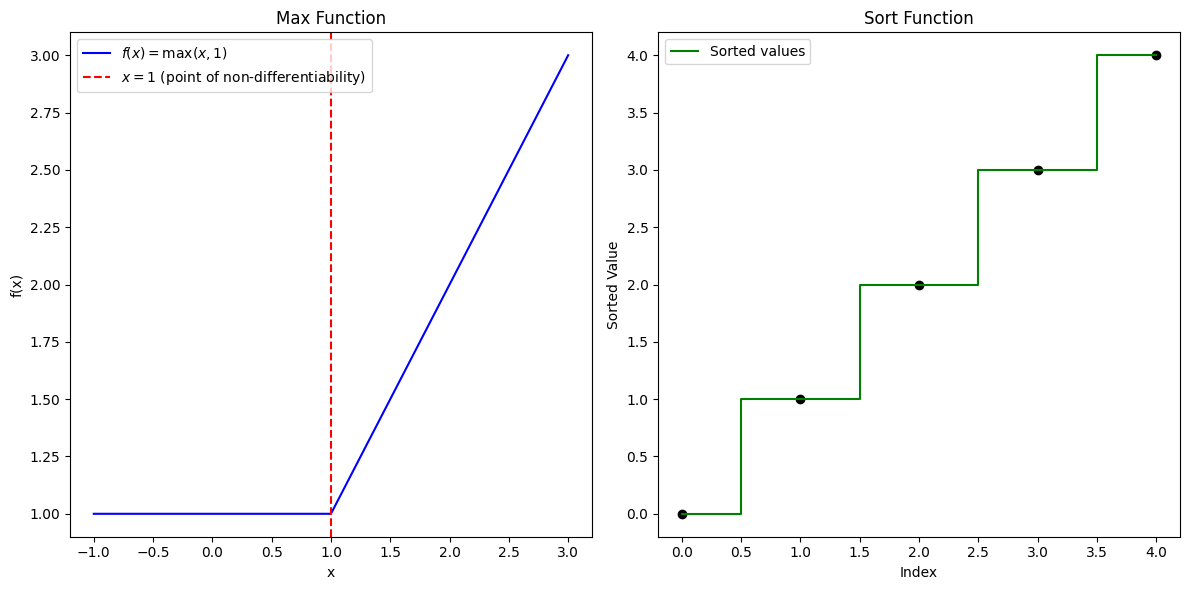

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to illustrate max and sort subdifferentials
x = np.linspace(-1, 3, 400)
y_max = np.maximum(x, 1)  # Max function example: max(x, 1)

# Plotting
plt.figure(figsize=(12, 6))

# Max function plot
plt.subplot(1, 2, 1)
plt.plot(x, y_max, label=r"$f(x) = \max(x, 1)$", color="blue")
plt.axvline(1, color="red", linestyle="--", label=r"$x=1$ (point of non-differentiability)")
plt.title("Max Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()

# Sort function plot (illustrating the largest value)
x_values = np.array([2, 3, 1, 4, 0])
sorted_values = np.sort(x_values)

plt.subplot(1, 2, 2)
plt.step(np.arange(len(sorted_values)), sorted_values, where="mid", label="Sorted values", color="green")
plt.scatter(np.arange(len(x_values)), sorted_values, color="black")
plt.title("Sort Function")
plt.xlabel("Index")
plt.ylabel("Sorted Value")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np
import sympy as sp

# sort() comparing the 3 methods

In [ ]:



def sort_function(x):
    return jnp.sort(x)[-1]  # Return the largest value after sorting

def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):  # Iterate over each component
        x_plus = x.copy()
        x_plus[i] += h  # Perturb one component by h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx

def symbolic_gradient_sort(x):
    x_symbols = sp.symbols(f"x0:{len(x)}")
    max_val = sp.Max(*x_symbols) 
    gradients = [sp.diff(max_val, xi) for xi in x_symbols]
    subs = {x_symbols[i]: x[i] for i in range(len(x))}
    grad_values = [float(grad.evalf(subs=subs)) for grad in gradients]

    return np.array(grad_values)



test_cases = [
    jnp.array([3.0, 1.0, 2.0]),  # Case 1: Distinct values
    jnp.array([1.0, 2.0, 2.0]),  # Case 2: Tied maximum values
    jnp.array([2.0, 2.0, 2.0])   # Case 3: All values are equal
]

for idx, x in enumerate(test_cases):
    jax_grad = grad(sort_function)(x)
    
    fd_grad = finite_difference(lambda y: np.sort(y)[-1], np.array(x))
    
    sym_grad = symbolic_gradient_sort(np.array(x))
    
    # Print results
    print(f"\nTest Case {idx + 1}: Input = {x}")
    print("JAX Gradient:\n", jax_grad)
    print("Finite Difference Gradient:\n", fd_grad)
    print("Symbolic Gradient:\n", sym_grad)
    




Test Case 1: Input = [3. 1. 2.]
JAX Gradient:
 [1. 0. 0.]
Finite Difference Gradient:
 [0.99897385 0.         0.        ]
Symbolic Gradient:
 [1. 0. 0.]

Test Case 2: Input = [1. 2. 2.]
JAX Gradient:
 [0. 0. 1.]
Finite Difference Gradient:
 [0.         0.99897385 0.99897385]
Symbolic Gradient:
 [0.  0.5 0.5]

Test Case 3: Input = [2. 2. 2.]
JAX Gradient:
 [0. 0. 1.]
Finite Difference Gradient:
 [0.99897385 0.99897385 0.99897385]
Symbolic Gradient:
 [0.5 0.5 0.5]


# min() comparing the 3 functions

In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np

# Test function using min
def min_function(x):
    return jnp.min(x)

# Finite difference gradient function
def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):  # Iterate over each component
        x_plus = x.copy()
        x_plus[i] += h  # Perturb one component by h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx


import sympy as sp
import numpy as np

def symbolic_gradient_min(x):
    """
    Compute symbolic gradients for the min value extracted from an array.

    Parameters
    ----------
    x : np.ndarray
        Input array for which to compute symbolic gradients.

    Returns
    -------
    np.ndarray
        Symbolic gradient values evaluated for the input array.
    """
    # Define symbolic variables
    x_symbols = sp.symbols(f"x0:{len(x)}")

    # Define the symbolic min function
    min_val = sp.Min(*x_symbols)  # Use sp.Min to represent the minimum value symbolically

    # Compute symbolic gradients
    gradients = [sp.diff(min_val, xi) for xi in x_symbols]

    # Substitute the input values and evaluate the gradients
    subs = {x_symbols[i]: x[i] for i in range(len(x))}
    grad_values = [float(grad.evalf(subs=subs)) for grad in gradients]

    return np.array(grad_values)


# Test cases
test_cases = [
    jnp.array([3.0, 1.0, 2.0]),  # Distinct values
    jnp.array([1.0, 2.0, 2.0]),  # Tied minimum values
    jnp.array([2.0, 2.0, 2.0])   # All values equal
]

results = []

for x in test_cases:
    # Compute the gradient using JAX
    jax_grad = grad(min_function)(x)

    # Compute the gradient using finite difference method
    fd_grad = finite_difference(lambda x: np.min(x), np.array(x))

    # Compute the gradient using symbolic differentiation
    sym_grad = symbolic_gradient_min(np.array(x))

    # Store the results
    results.append({
        "Input": x,
        "JAX Gradient": jax_grad,
        "Finite Difference Gradient": fd_grad,
        "Symbolic Gradient": sym_grad,
    })

# Print results
for idx, result in enumerate(results):
    print(f"Test Case {idx + 1}: Input = {result['Input']}")
    print("JAX Gradient:", result["JAX Gradient"])
    print("Finite Difference Gradient:", result["Finite Difference Gradient"])
    print("Symbolic Gradient:", result["Symbolic Gradient"])
    print("Difference (JAX - Finite Difference):", result["JAX Gradient"] - result["Finite Difference Gradient"])
    print("Difference (JAX - Symbolic):", result["JAX Gradient"] - result["Symbolic Gradient"])
    print()


# Test function using min
def min_function(x):
    return jnp.min(x)

# Finite difference gradient function
def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):  # Iterate over each component
        x_plus = x.copy()
        x_plus[i] += h  # Perturb one component by h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx






# Test cases
test_cases = [
    jnp.array([3.0, 1.0, 2.0]),  # Distinct values
    jnp.array([1.0, 2.0, 2.0]),  # Tied minimum values
    jnp.array([2.0, 2.0, 2.0])   # All values equal
]

results = []

for x in test_cases:
    # Compute the gradient using JAX
    jax_grad = grad(min_function)(x)

    # Compute the gradient using finite difference method
    fd_grad = finite_difference(lambda x: np.min(x), np.array(x))

    # Compute the gradient using symbolic differentiation
    sym_grad = symbolic_gradient_min(np.array(x))

    # Store the results
    results.append({
        "Input": x,
        "JAX Gradient": jax_grad,
        "Finite Difference Gradient": fd_grad,
        "Symbolic Gradient": sym_grad,
    })

# Print results
for idx, result in enumerate(results):
    print(f"Test Case {idx + 1}: Input = {result['Input']}")
    print("JAX Gradient:", result["JAX Gradient"])
    print("Finite Difference Gradient:", result["Finite Difference Gradient"])
    print("Symbolic Gradient:", result["Symbolic Gradient"])
    print("Difference (JAX - Finite Difference):", result["JAX Gradient"] - result["Finite Difference Gradient"])
    print("Difference (JAX - Symbolic):", result["JAX Gradient"] - result["Symbolic Gradient"])
    print()


Test Case 1: Input = [3. 1. 2.]
JAX Gradient: [0. 1. 0.]
Finite Difference Gradient: [0.        1.0001659 0.       ]
Symbolic Gradient: [0. 1. 0.]
Difference (JAX - Finite Difference): [ 0.         -0.00016594  0.        ]
Difference (JAX - Symbolic): [0. 0. 0.]

Test Case 2: Input = [1. 2. 2.]
JAX Gradient: [1. 0. 0.]
Finite Difference Gradient: [1.0001659 0.        0.       ]
Symbolic Gradient: [1. 0. 0.]
Difference (JAX - Finite Difference): [-0.00016594  0.          0.        ]
Difference (JAX - Symbolic): [0. 0. 0.]

Test Case 3: Input = [2. 2. 2.]
JAX Gradient: [0.33333334 0.33333334 0.33333334]
Finite Difference Gradient: [0. 0. 0.]
Symbolic Gradient: [0.5 0.5 0.5]
Difference (JAX - Finite Difference): [0.33333334 0.33333334 0.33333334]
Difference (JAX - Symbolic): [-0.16666666 -0.16666666 -0.16666666]

Test Case 1: Input = [3. 1. 2.]
JAX Gradient: [0. 1. 0.]
Finite Difference Gradient: [0.        1.0001659 0.       ]
Symbolic Gradient: [0. 1. 0.]
Difference (JAX - Finite Differ

In [ ]:
import jax.numpy as jnp
from jax import grad
import numpy as np

# Test function using max
def max_function(x):
    return jnp.max(x)

# Finite difference gradient function
def finite_difference(func, x, h=1e-4):
    grad_approx = np.zeros_like(x)
    for i in range(len(x)):  # Iterate over each component
        x_plus = x.copy()
        x_plus[i] += h  # Perturb one component by h
        grad_approx[i] = (func(x_plus) - func(x)) / h
    return grad_approx


import sympy as sp

def symbolic_gradient_max(x):
    """
    Compute symbolic gradients for the max value extracted from an array.

    Parameters
    ----------
    x : np.ndarray
        Input array for which to compute symbolic gradients.

    Returns
    -------
    np.ndarray
        Symbolic gradient values evaluated for the input array.
    """
    # Define symbolic variables
    x_symbols = sp.symbols(f"x0:{len(x)}")

    # Define the symbolic max function
    max_val = sp.Max(*x_symbols)  # Use sp.Max to represent the maximum value symbolically

    # Compute symbolic gradients
    gradients = [sp.diff(max_val, xi) for xi in x_symbols]

    # Substitute the input values and evaluate the gradients
    subs = {x_symbols[i]: x[i] for i in range(len(x))}
    grad_values = [float(grad.evalf(subs=subs)) for grad in gradients]

    return np.array(grad_values)



# Test cases
test_cases = [
    jnp.array([3.0, 1.0, 2.0]),  # Distinct values
    jnp.array([1.0, 2.0, 2.0]),  # Tied maximum values
    jnp.array([2.0, 2.0, 2.0])   # All values equal
]

results = []

for x in test_cases:
    # Compute the gradient using JAX
    jax_grad = grad(max_function)(x)

    # Compute the gradient using finite difference method
    fd_grad = finite_difference(lambda x: np.max(x), np.array(x))

    # Compute the gradient using symbolic differentiation
    sym_grad = symbolic_gradient_max(np.array(x))

    # Store the results
    results.append({
        "Input": x,
        "JAX Gradient": jax_grad,
        "Finite Difference Gradient": fd_grad,
        "Symbolic Gradient": sym_grad,
    })

# Print results
for idx, result in enumerate(results):
    print(f"Test Case {idx + 1}: Input = {result['Input']}")
    print("JAX Gradient:", result["JAX Gradient"])
    print("Finite Difference Gradient:", result["Finite Difference Gradient"])
    print("Symbolic Gradient:", result["Symbolic Gradient"])
    print("Difference (JAX - Finite Difference):", result["JAX Gradient"] - result["Finite Difference Gradient"])
    print("Difference (JAX - Symbolic):", result["JAX Gradient"] - result["Symbolic Gradient"])
    print()


Test Case 1: Input = [3. 1. 2.]
JAX Gradient: [1. 0. 0.]
Finite Difference Gradient: [0.99897385 0.         0.        ]
Symbolic Gradient: [1. 0. 0.]
Difference (JAX - Finite Difference): [0.00102615 0.         0.        ]
Difference (JAX - Symbolic): [0. 0. 0.]

Test Case 2: Input = [1. 2. 2.]
JAX Gradient: [0.  0.5 0.5]
Finite Difference Gradient: [0.         0.99897385 0.99897385]
Symbolic Gradient: [0.  0.5 0.5]
Difference (JAX - Finite Difference): [ 0.         -0.49897385 -0.49897385]
Difference (JAX - Symbolic): [0. 0. 0.]

Test Case 3: Input = [2. 2. 2.]
JAX Gradient: [0.33333334 0.33333334 0.33333334]
Finite Difference Gradient: [0.99897385 0.99897385 0.99897385]
Symbolic Gradient: [0.5 0.5 0.5]
Difference (JAX - Finite Difference): [-0.6656405 -0.6656405 -0.6656405]
Difference (JAX - Symbolic): [-0.16666666 -0.16666666 -0.16666666]



At the discontinuity caused by the tied maximum values (
2.0
2.0 at indices 
1
1 and 
2
2), JAX and symbolic differentiation correctly compute a convex combination of the gradients, assigning equal weight (
0.5
0.5) to both indices. The finite difference method fails to capture this behavior due to its reliance on perturbations, which do not adequately represent the non-smooth transition between tied maxima.  

For completely tied values, JAX computes a uniform convex combination of gradients, dividing responsibility equally among all indices. Symbolic differentiation provides an equal gradient of 
0.5
0.5, which aligns with a different convention but is consistent with the hyperplane condition of subgradients.
Finite difference again fails to account for the discontinuity, leading to overestimated gradients.  

JAX computes subgradients for the max() function based on Clarke's generalized gradient. The subgradient at a discontinuity is the convex hull of the gradients from all possible smooth regions near the discontinuity. This explains the uniform distribution observed in Test Case 3:

JAX Gradient: 
[
0.3333
,
0.3333
,
0.3333
]
.
JAX Gradient: [0.3333,0.3333,0.3333].